In [1]:
%load_ext autoreload
%autoreload 2
import os
import sys
import pickle

sys.path.append(os.path.abspath("../analysis_tools/"))
from utils import * 

# pycytominer imports
from pycytominer import aggregate, annotate, normalize, feature_select
from pycytominer import feature_select

# load first few rows from parquet
import fastparquet

# for median absolute deviation
import scipy.stats as ss
from scipy.special import logit

# kernel ridge regression
from sklearn.kernel_ridge import KernelRidge
from sklearn.linear_model import LinearRegression
from sklearn.svm import LinearSVC
from sklearn.calibration import CalibratedClassifierCV
from sklearn.model_selection import StratifiedKFold, cross_val_predict
from sklearn.metrics import roc_curve, auc, precision_score, recall_score, roc_auc_score, confusion_matrix

# make cell crops
import skimage.io

# upset plots
from upsetplot import generate_counts, plot
from upsetplot import UpSet

# coloring legends
from matplotlib.patches import Patch
import matplotlib.lines as mlines

# venn
from matplotlib_venn import venn3, venn3_circles


In [2]:
# information about pten
start_pos=112
end_pos=172
PTEN_domain_map = {}
for pos in range(start_pos, end_pos+1):
    if ((pos>=123) & (pos<=130)):
        PTEN_domain_map[pos] = "P loop"
    elif ((pos>=165) & (pos<=171)):
        PTEN_domain_map[pos] = "TI loop"
    else:
        PTEN_domain_map[pos] = "Other Phosphatase Domain"
PTEN_domain_coloring = {
    'Other Phosphatase Domain':'grey',
    'P loop':'lightcoral',
    'TI loop':'powderblue'
}
pymol_ptenview3 = \
'''set_view (\
    -0.839138746,   -0.157006517,   -0.520763457,\
     0.174852356,    0.828741431,   -0.531615376,\
     0.515042126,   -0.537154317,   -0.667978406,\
    -0.000375278,    0.000023644, -226.242431641,\
   109.331817627,  166.696105957,  124.016159058,\
    47.521118164,  404.805816650,  -20.000000000 )
'''


In [345]:
# Pull single cell feature information to find cells
# iPSC
features_to_pull = \
    [
     'Intensity_MeanIntensity_CH1',
     'Intensity_MeanIntensity_CH3_Corrected',
     'Correlation_Correlation_CH0_CH1'
    ]

r1_phenotyping_path = '/net/fowler/vol1/shared/fisseq/PTEN_iPSC/phenotyping/'
r2_phenotyping_path = '/net/fowler/vol1/shared/fisseq/PTEN_iPSCR2/phenotyping/'

# Import cell information
# iPSC
genotypes_df_r1 = \
    pd.read_parquet('../PTEN_iPSC_T3_pycytominer_pipelinev2_122224/R1_features/PTENT3R1.cellprofiler_121424.cells_full.parquet', 
                    columns=['virtualBarcode',
                             'aaChanges',
                             'editDistance',
                             'AreaShape_Center_X',
                             'AreaShape_Center_Y',
                             'tile_x',
                             'tile_y',
                             'tile_index',
                             'well']+\
                            features_to_pull
                   )
genotypes_df_r1 = \
    genotypes_df_r1\
       .assign(Replicate=1)\
       .query('editDistance in [0,1]')
genotypes_df_r1['CH2Path'] = \
    genotypes_df_r1.apply(lambda row: construct_phenotype_path(r1_phenotyping_path,
                                                               row['well'],
                                                               row['tile_x'],
                                                               row['tile_y'],
                                                               filename='channel2.tif'), 
                          axis=1)
genotypes_df_r1['pAKTPath'] = \
    genotypes_df_r1.apply(lambda row: construct_phenotype_path(r1_phenotyping_path,
                                                               row['well'],
                                                               row['tile_x'],
                                                               row['tile_y'],
                                                               filename='channel3.tif'), 
                          axis=1)
genotypes_df_r1['PhenotypePath'] = \
    genotypes_df_r1.apply(lambda row: construct_phenotype_path(r1_phenotyping_path,
                                                               row['well'],
                                                               row['tile_x'],
                                                               row['tile_y']), 
                          axis=1)
genotypes_df_r1['DAPIPath'] = \
    genotypes_df_r1.apply(lambda row: construct_phenotype_path(r1_phenotyping_path,
                                                               row['well'],
                                                               row['tile_x'],
                                                               row['tile_y'],
                                                               filename='channel0.tif'), 
                          axis=1)
genotypes_df_r1['CellMaskPath'] = \
    genotypes_df_r1.apply(lambda row: construct_phenotype_path(r1_phenotyping_path,
                                                               row['well'],
                                                               row['tile_x'],
                                                               row['tile_y'],
                                                               filename='cells.tif'), 
                          axis=1)

genotypes_df_r2 = \
    pd.read_parquet('/net/fowler/vol1/shared/fisseq/PTEN_iPSCR2/output/wellall_seqgrid5_phenogrid20.cellprofiler_121424.cells_full.parquet', 
                    columns=['virtualBarcode',
                             'aaChanges',
                             'editDistance',
                             'AreaShape_Center_X',
                             'AreaShape_Center_Y',
                             'tile_x',
                             'tile_y',
                             'tile_index',
                             'well']+\
                            features_to_pull
                   )
genotypes_df_r2 = \
    genotypes_df_r2\
       .assign(Replicate=2)\
       .query('editDistance in [0,1]')
genotypes_df_r2['CH2Path'] = \
    genotypes_df_r2.apply(lambda row: construct_phenotype_path(r2_phenotyping_path,
                                                               row['well'],
                                                               row['tile_x'],
                                                               row['tile_y'],
                                                               filename='channel2.tif'), 
                          axis=1)
genotypes_df_r2['pAKTPath'] = \
    genotypes_df_r2.apply(lambda row: construct_phenotype_path(r2_phenotyping_path,
                                                               row['well'],
                                                               row['tile_x'],
                                                               row['tile_y'],
                                                               filename='channel3.tif'), 
                          axis=1)
genotypes_df_r2['PhenotypePath'] = \
    genotypes_df_r2.apply(lambda row: construct_phenotype_path(r2_phenotyping_path,
                                                               row['well'],
                                                               row['tile_x'],
                                                               row['tile_y'],
                                                               filename='channel1.tif'), 
                          axis=1)
genotypes_df_r2['DAPIPath'] = \
    genotypes_df_r2.apply(lambda row: construct_phenotype_path(r2_phenotyping_path,
                                                               row['well'],
                                                               row['tile_x'],
                                                               row['tile_y'],
                                                               filename='channel0.tif'), 
                          axis=1)
genotypes_df_r2['CellMaskPath'] = \
    genotypes_df_r2.apply(lambda row: construct_phenotype_path(r2_phenotyping_path,
                                                               row['well'],
                                                               row['tile_x'],
                                                               row['tile_y'],
                                                               filename='cells.tif'), 
                          axis=1)

# merge
genotypes_iPSC_df = pd.concat([genotypes_df_r1,genotypes_df_r2], axis=0)


In [346]:
# Pull single cell feature information to find cells
# Neuron
features_to_pull = \
    [
     'Intensity_MeanIntensity_CH1',
     'Intensity_MeanIntensity_CH3_Corrected',
     'Correlation_Correlation_CH0_CH1'
    ]

r1_phenotyping_path = '/net/fowler/vol1/shared/fisseq/PTEN_Neurons/phenotyping/'
r2_phenotyping_path = '/net/fowler/vol1/shared/fisseq/PTEN_NeuronsR2/phenotyping/'

# Import cell information
# iPSC
genotypes_df_r1 = \
    pd.read_parquet('./R1_features/PTENT3R1.cellprofiler_121424.cells_full.parquet', 
                    columns=['virtualBarcode',
                             'aaChanges',
                             'editDistance',
                             'AreaShape_Center_X',
                             'AreaShape_Center_Y',
                             'tile_x',
                             'tile_y',
                             'well']+\
                            features_to_pull
                   )
genotypes_df_r1 = \
    genotypes_df_r1\
        .assign(Replicate=1)\
        .query('editDistance in [0,1]')\
        .query('well in ["1","2","3","4","5","6"]')
genotypes_df_r1['CH2Path'] = \
    genotypes_df_r1.apply(lambda row: construct_phenotype_path(r1_phenotyping_path,
                                                               row['well'],
                                                               row['tile_x'],
                                                               row['tile_y'],
                                                               filename='channel2.tif'), 
                          axis=1)
genotypes_df_r1['pAKTPath'] = \
    genotypes_df_r1.apply(lambda row: construct_phenotype_path(r1_phenotyping_path,
                                                               row['well'],
                                                               row['tile_x'],
                                                               row['tile_y'],
                                                               filename='channel3.tif'), 
                          axis=1)
genotypes_df_r1['PhenotypePath'] = \
    genotypes_df_r1.apply(lambda row: construct_phenotype_path(r1_phenotyping_path,
                                                               row['well'],
                                                               row['tile_x'],
                                                               row['tile_y']), 
                          axis=1)
genotypes_df_r1['DAPIPath'] = \
    genotypes_df_r1.apply(lambda row: construct_phenotype_path(r1_phenotyping_path,
                                                               row['well'],
                                                               row['tile_x'],
                                                               row['tile_y'],
                                                               filename='channel0.tif'), 
                          axis=1)
genotypes_df_r1['CellMaskPath'] = \
    genotypes_df_r1.apply(lambda row: construct_phenotype_path(r1_phenotyping_path,
                                                               row['well'],
                                                               row['tile_x'],
                                                               row['tile_y'],
                                                               filename='cells.tif'), 
                          axis=1)

genotypes_df_r2 = \
    pd.read_parquet('./R2_features/PTENT3R2.cellprofiler_121424.cells_full.parquet', 
                    columns=['virtualBarcode',
                             'aaChanges',
                             'editDistance',
                             'AreaShape_Center_X',
                             'AreaShape_Center_Y',
                             'tile_x',
                             'tile_y',
                             'well']+\
                            features_to_pull
                   )
genotypes_df_r2 = \
    genotypes_df_r2\
        .assign(Replicate=2)\
        .query('editDistance in [0,1]')\
        .query('well in ["1","2","3","4","5","6"]')
genotypes_df_r2['CH2Path'] = \
    genotypes_df_r2.apply(lambda row: construct_phenotype_path(r2_phenotyping_path,
                                                               row['well'],
                                                               row['tile_x'],
                                                               row['tile_y'],
                                                               filename='channel2.tif'), 
                          axis=1)
genotypes_df_r2['pAKTPath'] = \
    genotypes_df_r2.apply(lambda row: construct_phenotype_path(r2_phenotyping_path,
                                                               row['well'],
                                                               row['tile_x'],
                                                               row['tile_y'],
                                                               filename='channel3.tif'), 
                          axis=1)
genotypes_df_r2['PhenotypePath'] = \
    genotypes_df_r2.apply(lambda row: construct_phenotype_path(r2_phenotyping_path,
                                                               row['well'],
                                                               row['tile_x'],
                                                               row['tile_y'],
                                                               filename='channel1.tif'), 
                          axis=1)
genotypes_df_r2['DAPIPath'] = \
    genotypes_df_r2.apply(lambda row: construct_phenotype_path(r2_phenotyping_path,
                                                               row['well'],
                                                               row['tile_x'],
                                                               row['tile_y'],
                                                               filename='channel0.tif'), 
                          axis=1)
genotypes_df_r2['CellMaskPath'] = \
    genotypes_df_r2.apply(lambda row: construct_phenotype_path(r2_phenotyping_path,
                                                               row['well'],
                                                               row['tile_x'],
                                                               row['tile_y'],
                                                               filename='cells.tif'), 
                          axis=1)

# merge
genotypes_neuron_df = pd.concat([genotypes_df_r1,genotypes_df_r2], axis=0)


In [3]:
# Import profiles - iPSC
# R1
# Save profiles
df_profiles_iPSC_R1 = \
    pd.read_csv('../PTEN_iPSC_T3_pycytominer_pipelinev2_122224/R1_features/PTENT3R1.iPSC.embeddings.010425.csv')
df_profiles_iPSC_R1.drop(columns='Unnamed: 0',inplace=True)
feat_selected_iPSC_R1 = [s for s in df_profiles_iPSC_R1.columns\
                                if s not in ['Variant',
                                             'Variant_Class',
                                             'Metadata_Object_Count',
                                             'UMAP1',
                                             'UMAP2']
                        ]
var_iPSC_R1 = df_profiles_iPSC_R1.Variant
df_profiles_iPSC_R1.drop(columns='Variant',inplace=True)
df_profiles_iPSC_R1.index = var_iPSC_R1

# R2
df_profiles_iPSC_R2 = \
    pd.read_csv('../PTEN_iPSC_T3_pycytominer_pipelinev2_122224/R2_features/PTENT3R2.iPSC.embeddings.010425.csv')
df_profiles_iPSC_R2.drop(columns='Unnamed: 0')
feat_selected_iPSC_R2 = [s for s in df_profiles_iPSC_R2.columns\
                                if s not in ['Variant',
                                             'Variant_Class',
                                             'Metadata_Object_Count',
                                             'UMAP1',
                                             'UMAP2']
                        ]
var_iPSC_R2 = df_profiles_iPSC_R2.Variant
df_profiles_iPSC_R2.drop(columns='Variant',inplace=True)
df_profiles_iPSC_R2.index = var_iPSC_R2

# merge by taking average
var_common = list(set(var_iPSC_R1).intersection(set(var_iPSC_R2)))
feat_common = list(set(feat_selected_iPSC_R1).intersection(set(feat_selected_iPSC_R2)))
df_profiles_iPSC_merged = \
    (df_profiles_iPSC_R1.loc[var_common,feat_common] + df_profiles_iPSC_R2.loc[var_common,feat_common])/2 #Average profiles
df_profiles_iPSC_merged['NCells_iPSC_R1'] = df_profiles_iPSC_R1.loc[var_common,'Metadata_Object_Count']
df_profiles_iPSC_merged['NCells_iPSC_R2'] = df_profiles_iPSC_R2.loc[var_common,'Metadata_Object_Count']
df_profiles_iPSC_merged.reset_index(inplace=True)
df_profiles_iPSC_merged['Variant_Class'] = \
    pd.Categorical(df_profiles_iPSC_merged['Variant'].astype(str).apply(variant_classification),
                       categories=mutation_types, ordered=True)
var_common_iPSC = var_common.copy()
feat_common_iPSC = feat_common.copy()


In [4]:
len(var_common_iPSC)

1302

In [5]:
len(feat_common_iPSC)

1174

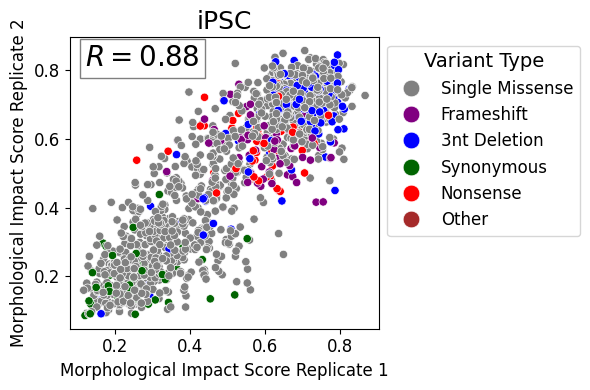

In [6]:
# Plot correlation between impact scores for replicates
df_profiles_R1_synmedian = \
    df_profiles_iPSC_R1\
        .query('Variant_Class == "Synonymous"')\
        [feat_common].agg(np.median)
variant_cosine_similarity_iPSC_R1 = \
    cosine_similarity(df_profiles_iPSC_R1[feat_common], df_profiles_R1_synmedian.values.reshape(1,-1))
df_profiles_iPSC_R1['Morphological Impact Score'] = \
    (1-variant_cosine_similarity_iPSC_R1[:,0])/2

df_profiles_R2_synmedian = \
    df_profiles_iPSC_R2\
        .query('Variant_Class == "Synonymous"')\
        [feat_common].agg(np.median)
variant_cosine_similarity_iPSC_R2 = \
    cosine_similarity(df_profiles_iPSC_R2[feat_common], df_profiles_R2_synmedian.values.reshape(1,-1))
df_profiles_iPSC_R2['Morphological Impact Score'] = \
    (1-variant_cosine_similarity_iPSC_R2[:,0])/2

# Compute correlation plot between morphological impact scores
# Compute linear regression parameters
r1_mis = df_profiles_iPSC_R1.loc[var_common,'Morphological Impact Score']
r2_mis = df_profiles_iPSC_R2.loc[var_common,'Morphological Impact Score']

slope, intercept, r_value, p_value, std_err = ss.linregress(r1_mis,r2_mis)
r_squared = r_value**2

# Prepare line values for the best-fit line
line_x = np.linspace(r1_mis.min(), r1_mis.max(), 100)
line_y = slope * line_x + intercept

# # Plot
fig, ax = plt.subplots(figsize=(6,4))
sns.scatterplot(x=r1_mis, 
                y=r2_mis, 
                hue=df_profiles_iPSC_R1.loc[var_common,'Variant_Class'],
                palette=variant_type_palette,
                ax=ax)
# ax.plot(line_x, line_y, color='black', label='_nolegend_')

# Add labels
ax.set_xlabel('Morphological Impact Score Replicate 1', fontsize=12)
ax.set_ylabel('Morphological Impact Score Replicate 2', fontsize=12)
ax.tick_params(labelsize=12)

# Display R^2 on the plot
ax.text(
    0.05, 0.9, 
    f'$R = {r_value:.2f}$', 
    transform=ax.transAxes, 
    fontsize=20, 
    bbox=dict(facecolor='white', alpha=0.5)
)

# Show legend and plot
ax.legend(bbox_to_anchor=(1,1), markerscale=2, title='Variant Type', title_fontsize=14, fontsize=12)
plt.title('iPSC', fontsize=18)
plt.tight_layout()
fig.savefig('./consensus_plots/PTENT3.iPSC.morphologicalimpactscore.correlationbetweenreps.011325.pdf', dpi=600)
plt.show()


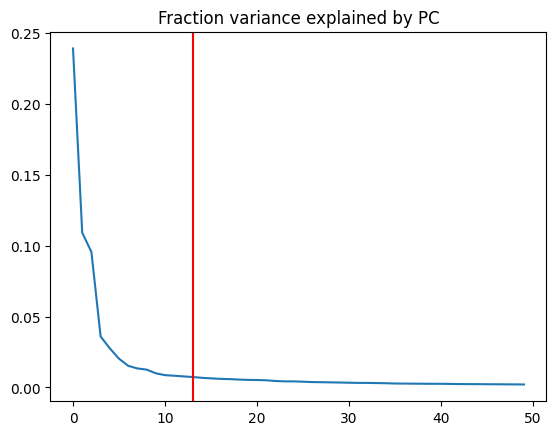

PCA dimensions: 13


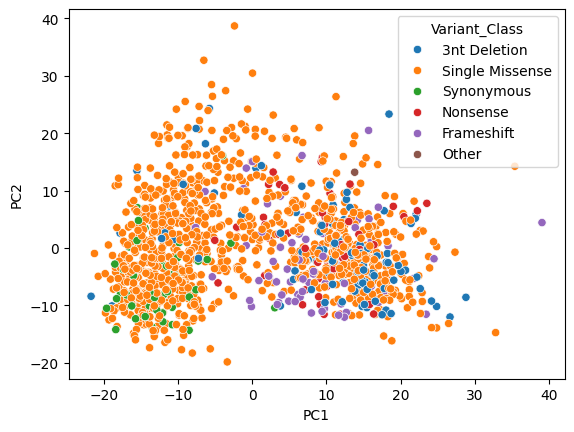

In [7]:
# Perform PCA to get fraction variance explained plot
n_comp_pca_test=50
pca = PCA(n_components=n_comp_pca_test)
variant_medianplusemd_scaled = df_profiles_iPSC_merged[feat_common].values
variant_medianplusemd_pca = pca.fit_transform(variant_medianplusemd_scaled)

# Plot fraction variance explained
plt.plot(list(range(n_comp_pca_test)), pca.explained_variance_ratio_)
plt.title('Fraction variance explained by PC')

# choose number of PCA dim to explain >60% of variance
var_explained_thresh = 0.60
pca_var_explained = np.asarray([np.sum(pca.explained_variance_ratio_[:i]) for i in range(n_comp_pca_test)])
n_comp_pca=sum(pca_var_explained <= var_explained_thresh)
plt.axvline(x=n_comp_pca, c='r')
plt.show()

# perform PCA again
print('PCA dimensions: ' + str(n_comp_pca))
pca = PCA(n_components=n_comp_pca)
variant_medianplusemd_pca = pca.fit_transform(variant_medianplusemd_scaled)
df_variant_medianplusEMD_features_pca = \
    pd.DataFrame(data = variant_medianplusemd_pca, 
                 columns=['PC'+str(i+1) for i in range(n_comp_pca)])
df_variant_medianplusEMD_features_pca['Variant'] = df_profiles_iPSC_merged['Variant']
df_variant_medianplusEMD_features_pca['Variant_Class'] = df_profiles_iPSC_merged['Variant_Class']
df_pca_iPSC = df_variant_medianplusEMD_features_pca.copy()

# Plot PC1 vs 2
sns.scatterplot(
    data=df_variant_medianplusEMD_features_pca,
    x='PC1',
    y='PC2',
    hue='Variant_Class'
)
plt.show()


In [8]:
# Perform UMAP of median and EMD values
umap_model = umap.UMAP(n_neighbors=15,
                       random_state=42, 
                       metric='cosine', 
                       n_components=2)
umap_embedding_means = umap_model.fit_transform(variant_medianplusemd_pca)
df_profiles_iPSC_merged['UMAP1'] = umap_embedding_means[:,0]
df_profiles_iPSC_merged['UMAP2'] = umap_embedding_means[:,1]


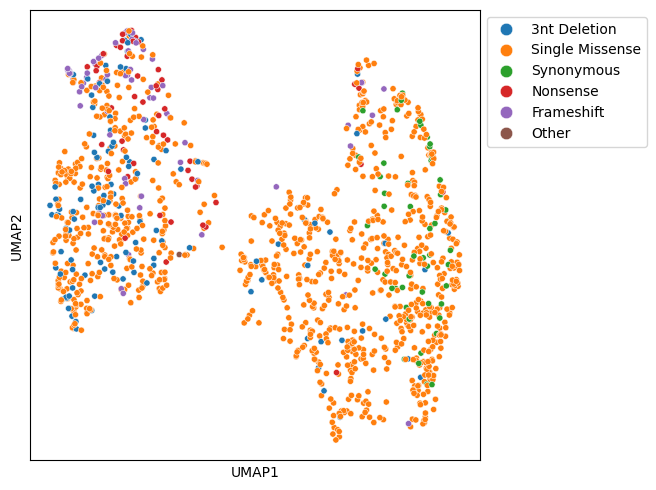

In [9]:
# Plot UMAP - iPSC
fig,ax=plt.subplots(figsize=(5,5))
sns.scatterplot(data=df_profiles_iPSC_merged, 
                     x='UMAP1', 
                     y='UMAP2', 
                     hue='Variant_Class',
                     s=20)
plt.legend(markerscale=2,  
           title='Variant Type')

# Remove x-axis tick labels and ticks
plt.xticks([])

# Remove y-axis tick labels and ticks
plt.yticks([])
plt.tight_layout()
ax.legend(loc='upper left', bbox_to_anchor=(1,1), markerscale=2)
fig.savefig('./consensus_plots/PTENT3.iPSC.UMAP.011425.pdf', dpi=600)
plt.show()


In [673]:
df_profiles_iPSC_merged.to_csv('./consensus_features/PTENT3.iPSC.consensusprofiles.011425.csv')

In [10]:
# Import profiles - neuron
# R1
# Save profiles
df_profiles_neuron_R1 = \
    pd.read_csv('./R1_features/PTENT3R1.Neuron.embeddings.010425.csv')
df_profiles_neuron_R1.drop(columns='Unnamed: 0',inplace=True)
feat_selected_neuron_R1 = [s for s in df_profiles_neuron_R1.columns\
                                if s not in ['Variant',
                                             'Variant_Class',
                                             'Metadata_Object_Count',
                                             'UMAP1',
                                             'UMAP2']
                   ]
var_neuron_R1 = df_profiles_neuron_R1.Variant
df_profiles_neuron_R1.drop(columns='Variant',inplace=True)
df_profiles_neuron_R1.index = var_neuron_R1

# R2
df_profiles_neuron_R2 = \
    pd.read_csv('./R2_features/PTENT3R2.Neuron.embeddings.010425.csv')
df_profiles_neuron_R2.drop(columns='Unnamed: 0')
feat_selected_neuron_R2 = [s for s in df_profiles_neuron_R2.columns\
                                if s not in ['Variant',
                                             'Variant_Class',
                                             'Metadata_Object_Count',
                                             'UMAP1',
                                             'UMAP2']
                   ]
var_neuron_R2 = df_profiles_neuron_R2.Variant
df_profiles_neuron_R2.drop(columns='Variant',inplace=True)
df_profiles_neuron_R2.index = var_neuron_R2

# merge by taking average
var_common = list(set(var_neuron_R1).intersection(set(var_neuron_R2)))
feat_common = list(set(feat_selected_neuron_R1).intersection(set(feat_selected_neuron_R2)))
df_profiles_neuron_merged = \
    (df_profiles_neuron_R1.loc[var_common,feat_common] + df_profiles_neuron_R2.loc[var_common,feat_common])/2 #Average profiles
df_profiles_neuron_merged['NCells_neuron_R1'] = df_profiles_neuron_R1.loc[var_common,'Metadata_Object_Count']
df_profiles_neuron_merged['NCells_neuron_R2'] = df_profiles_neuron_R2.loc[var_common,'Metadata_Object_Count']
df_profiles_neuron_merged.reset_index(inplace=True)
df_profiles_neuron_merged['Variant_Class'] = \
    pd.Categorical(df_profiles_neuron_merged['Variant'].astype(str).apply(variant_classification),
                       categories=mutation_types, ordered=True)
var_common_neuron = var_common.copy()
feat_common_neuron = feat_common.copy()


In [11]:
len(var_common_neuron)

1262

In [12]:
len(feat_common_neuron)

1036

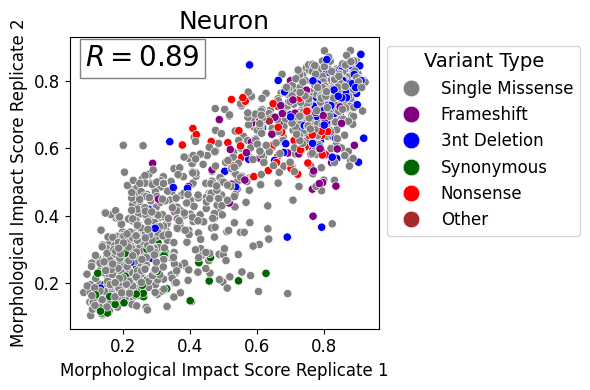

In [13]:
# Plot correlation between impact scores for replicates
df_profiles_R1_synmedian = \
    df_profiles_neuron_R1\
        .query('Variant_Class == "Synonymous"')\
        [feat_common].agg(np.median)
variant_cosine_similarity_neuron_R1 = \
    cosine_similarity(df_profiles_neuron_R1[feat_common], df_profiles_R1_synmedian.values.reshape(1,-1))
df_profiles_neuron_R1['Morphological Impact Score'] = \
    (1-variant_cosine_similarity_neuron_R1[:,0])/2

df_profiles_R2_synmedian = \
    df_profiles_neuron_R2\
        .query('Variant_Class == "Synonymous"')\
        [feat_common].agg(np.median)
variant_cosine_similarity_neuron_R2 = \
    cosine_similarity(df_profiles_neuron_R2[feat_common], df_profiles_R2_synmedian.values.reshape(1,-1))
df_profiles_neuron_R2['Morphological Impact Score'] = \
    (1-variant_cosine_similarity_neuron_R2[:,0])/2

# Compute correlation plot between morphological impact scores
# Compute linear regression parameters
r1_mis = df_profiles_neuron_R1.loc[var_common,'Morphological Impact Score']
r2_mis = df_profiles_neuron_R2.loc[var_common,'Morphological Impact Score']

slope, intercept, r_value, p_value, std_err = ss.linregress(r1_mis,r2_mis)
r_squared = r_value**2

# Prepare line values for the best-fit line
line_x = np.linspace(r1_mis.min(), r1_mis.max(), 100)
line_y = slope * line_x + intercept

# Plot
fig, ax = plt.subplots(figsize=(6,4))
sns.scatterplot(x=r1_mis, 
                y=r2_mis, 
                hue=df_profiles_neuron_R1.loc[var_common,'Variant_Class'],
                palette=variant_type_palette,
                ax=ax)
#ax.plot(line_x, line_y, color='black', label='_nolegend_')

# Add labels
ax.set_xlabel('Morphological Impact Score Replicate 1', fontsize=12)
ax.set_ylabel('Morphological Impact Score Replicate 2', fontsize=12)
ax.tick_params(labelsize=12)

# Display R^2 on the plot
ax.text(
    0.05, 0.9, 
    f'$R = {r_value:.2f}$', 
    transform=ax.transAxes, 
    fontsize=20, 
    bbox=dict(facecolor='white', alpha=0.5)
)

# Show legend and plot
ax.legend(bbox_to_anchor=(1,1), markerscale=2, title='Variant Type', title_fontsize=14, fontsize=12)
plt.title('Neuron', fontsize=18)
plt.tight_layout()
fig.savefig('./consensus_plots/PTENT3.neuron.morphologicalimpactscore.correlationbetweenreps.011325.pdf', dpi=600)
plt.show()


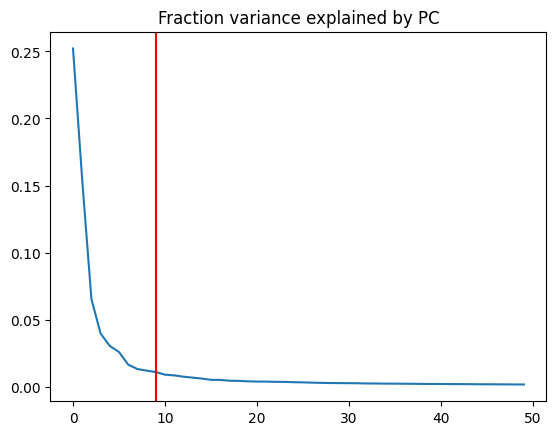

PCA dimensions: 9


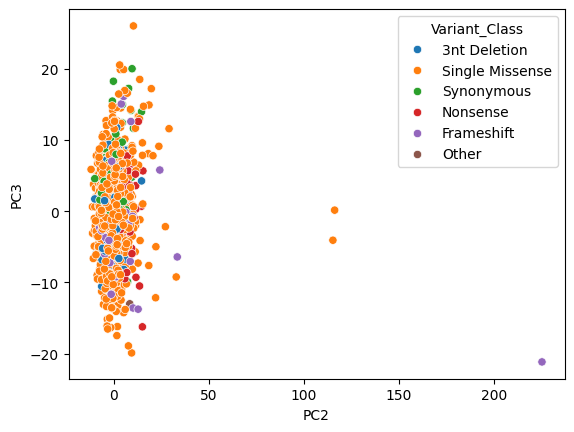

In [14]:
# Perform PCA to get fraction variance explained plot
n_comp_pca_test=50
pca = PCA(n_components=n_comp_pca_test)
variant_medianplusemd_scaled = df_profiles_neuron_merged[feat_common].values
variant_medianplusemd_pca = pca.fit_transform(variant_medianplusemd_scaled)

# Plot fraction variance explained
plt.plot(list(range(n_comp_pca_test)), pca.explained_variance_ratio_)
plt.title('Fraction variance explained by PC')

# choose number of PCA dim to explain >60% of variance
var_explained_thresh = 0.60
pca_var_explained = np.asarray([np.sum(pca.explained_variance_ratio_[:i]) for i in range(n_comp_pca_test)])
n_comp_pca=sum(pca_var_explained <= var_explained_thresh)
plt.axvline(x=n_comp_pca, c='r')
plt.show()

# perform PCA again
print('PCA dimensions: ' + str(n_comp_pca))
pca = PCA(n_components=n_comp_pca)
variant_medianplusemd_pca = pca.fit_transform(variant_medianplusemd_scaled)
df_variant_medianplusEMD_features_pca = \
    pd.DataFrame(data = variant_medianplusemd_pca, 
                 columns=['PC'+str(i+1) for i in range(n_comp_pca)])
df_variant_medianplusEMD_features_pca['Variant'] = df_profiles_neuron_merged['Variant']
df_variant_medianplusEMD_features_pca['Variant_Class'] = df_profiles_neuron_merged['Variant_Class']

# Plot PC1 vs 2
sns.scatterplot(
    data=df_variant_medianplusEMD_features_pca,
    x='PC2',
    y='PC3',
    hue='Variant_Class'
)
plt.show()


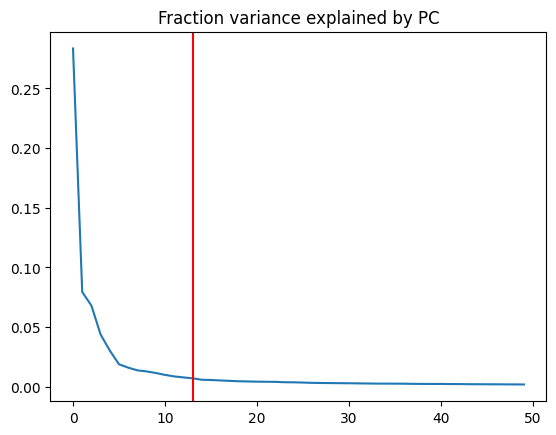

PCA dimensions: 13


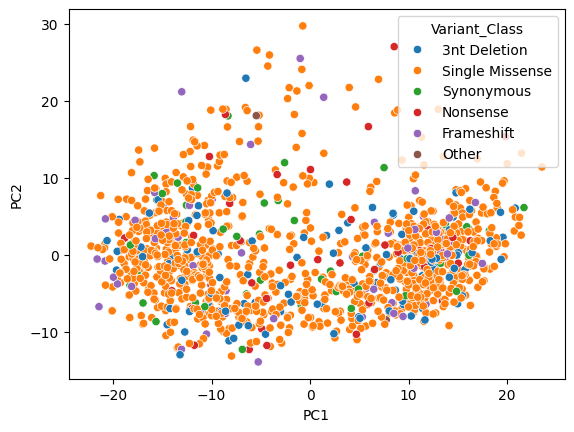

In [15]:
# Remove extreme outliers and run PCA again
outliers = \
    df_variant_medianplusEMD_features_pca\
        .query('PC2 >= 50')\
        ['Variant']
df_profiles_neuron_merged = \
    df_profiles_neuron_merged\
        .query('Variant not in @outliers')

# Perform PCA to get fraction variance explained plot
n_comp_pca_test=50
pca = PCA(n_components=n_comp_pca_test)
variant_medianplusemd_scaled = df_profiles_neuron_merged[feat_common].values
variant_medianplusemd_pca = pca.fit_transform(variant_medianplusemd_scaled)

# Plot fraction variance explained
plt.plot(list(range(n_comp_pca_test)), pca.explained_variance_ratio_)
plt.title('Fraction variance explained by PC')

# choose number of PCA dim to explain >60% of variance
var_explained_thresh = 0.60
pca_var_explained = np.asarray([np.sum(pca.explained_variance_ratio_[:i]) for i in range(n_comp_pca_test)])
n_comp_pca=sum(pca_var_explained <= var_explained_thresh)
plt.axvline(x=n_comp_pca, c='r')
plt.show()

# perform PCA again
print('PCA dimensions: ' + str(n_comp_pca))
pca = PCA(n_components=n_comp_pca)
variant_medianplusemd_pca = pca.fit_transform(variant_medianplusemd_scaled)
df_variant_medianplusEMD_features_pca = \
    pd.DataFrame(data = variant_medianplusemd_pca, 
                 columns=['PC'+str(i+1) for i in range(n_comp_pca)])
df_variant_medianplusEMD_features_pca['Variant'] = df_profiles_neuron_merged['Variant']
df_variant_medianplusEMD_features_pca['Variant_Class'] = df_profiles_neuron_merged['Variant_Class']
df_pca_neuron = df_variant_medianplusEMD_features_pca.copy()

# Plot PC1 vs 2
sns.scatterplot(
    data=df_variant_medianplusEMD_features_pca,
    x='PC1',
    y='PC2',
    hue='Variant_Class'
)
plt.show()


In [16]:
# Perform UMAP of median and EMD values
umap_model = umap.UMAP(n_neighbors=15, 
                       random_state=42, 
                       metric='cosine', 
                       n_components=2)
umap_embedding_means = umap_model.fit_transform(variant_medianplusemd_pca)
df_profiles_neuron_merged['UMAP1'] = umap_embedding_means[:,0]
df_profiles_neuron_merged['UMAP2'] = umap_embedding_means[:,1]


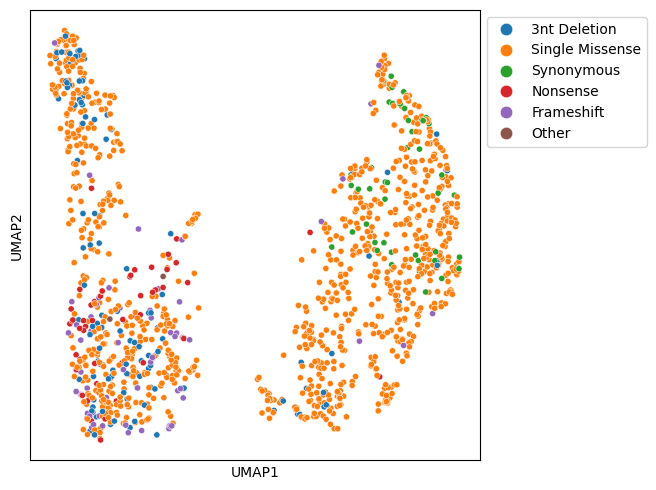

In [17]:
# Plot UMAP - neuron
fig,ax=plt.subplots(figsize=(5,5))
sns.scatterplot(data=df_profiles_neuron_merged, 
                     x='UMAP1', 
                     y='UMAP2', 
                     hue='Variant_Class',
                     s=20)
plt.legend(markerscale=2,  
           title='Variant Type')

# Remove x-axis tick labels and ticks
plt.xticks([])

# Remove y-axis tick labels and ticks
plt.yticks([])
plt.tight_layout()
ax.legend(loc='upper left', bbox_to_anchor=(1,1), markerscale=2)
fig.savefig('./consensus_plots/PTENT3.neuron.UMAP.011425.pdf', dpi=600)
plt.show()


In [681]:
df_profiles_neuron_merged.to_csv('./consensus_features/PTENT3.neuron.consensusprofiles.011425.csv')

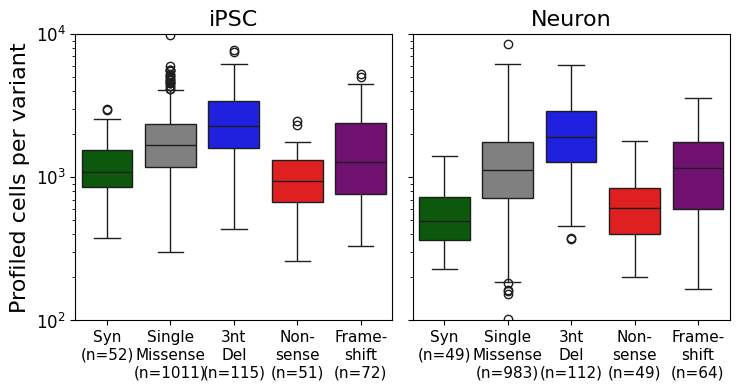

In [27]:
# Plot number of cells for each type of variant
df_profiles_toplot = df_profiles_iPSC_merged.copy()
df_profiles_toplot['NCells_Tot_iPSC'] = df_profiles_toplot['NCells_iPSC_R1']+df_profiles_toplot['NCells_iPSC_R2']

fig,axs=plt.subplots(figsize=(7.5,4), ncols=2, sharey=True)
boxplot_with_significance(
    df_profiles_toplot,
    x_col="Variant_Class",
    y_col="NCells_Tot_iPSC",
    hue_col=None,
    order=['Synonymous','Single Missense','3nt Deletion','Nonsense','Frameshift'],
    palette=variant_type_palette,
    alpha=0.001,
    pairs=None,            # list of (group1, group2) pairs to compare
    shared_label="***",    # text to show if any comparison is p < alpha
    offset=0.02,
    anno_sample_sizes=True,
    xlabels=["Syn","Single\nMissense","3nt\nDel","Non-\nsense","Frame-\nshift"],
    xlabel_fontsize=11,
    ax=axs[0]
)
axs[0].set_yscale('log')
axs[0].set_xlabel("")
axs[0].set_ylabel('Profiled cells per variant', fontsize=16)
axs[0].tick_params(axis='y', labelsize=12)
axs[0].set_ylim(10**2,10**4)
axs[0].set_title("iPSC", fontsize=16)

df_profiles_toplot = df_profiles_neuron_merged.copy()
df_profiles_toplot['NCells_Tot_neuron'] = df_profiles_toplot['NCells_neuron_R1']+df_profiles_toplot['NCells_neuron_R2']

boxplot_with_significance(
    df_profiles_toplot,
    x_col="Variant_Class",
    y_col="NCells_Tot_neuron",
    hue_col=None,
    order=['Synonymous','Single Missense','3nt Deletion','Nonsense','Frameshift'],
    palette=variant_type_palette,
    alpha=0.001,
    pairs=None,            # list of (group1, group2) pairs to compare
    shared_label="***",    # text to show if any comparison is p < alpha
    offset=0.02,
    anno_sample_sizes=True,
    xlabels=["Syn","Single\nMissense","3nt\nDel","Non-\nsense","Frame-\nshift"],
    xlabel_fontsize=11,
    ax=axs[1]
)
axs[1].set_xlabel("")
axs[1].set_title("Neuron", fontsize=16)

plt.tight_layout()
plt.show()
fig.savefig('./consensus_plots/ntotalcells.PTEN.052725.pdf', dpi=600)


In [18]:
# Read iPS and neuron profiles
df_profiles_iPSC_merged = \
    pd.read_csv('./consensus_features/PTENT3.iPSC.consensusprofiles.011425.csv')
df_profiles_neuron_merged = \
    pd.read_csv('./consensus_features/PTENT3.neuron.consensusprofiles.011425.csv')


In [19]:
# Merge profiles
feat_total = [f+'_iPSC' for f in feat_common_iPSC] + [f+'_neuron' for f in feat_common_neuron]
df_profiles_merged = \
    df_profiles_iPSC_merged[['Variant']+feat_common_iPSC+['UMAP1','UMAP2','NCells_iPSC_R1','NCells_iPSC_R2']]\
        .rename(columns={f:f+'_iPSC' for f in feat_common_iPSC})\
        .rename(columns={f:f+' iPSC' for f in ['UMAP1','UMAP2']})\
        .merge(df_profiles_neuron_merged[['Variant']+feat_common_neuron+['UMAP1','UMAP2','NCells_neuron_R1','NCells_neuron_R2']]\
                   .rename(columns={f:f+'_neuron' for f in feat_common_neuron})\
                   .rename(columns={f:f+' neuron' for f in ['UMAP1','UMAP2']}),
               on='Variant',
               how='inner')
df_profiles_merged['Variant_Class'] = \
    pd.Categorical(df_profiles_merged['Variant'].astype(str).apply(variant_classification),
                       categories=mutation_types, ordered=True)


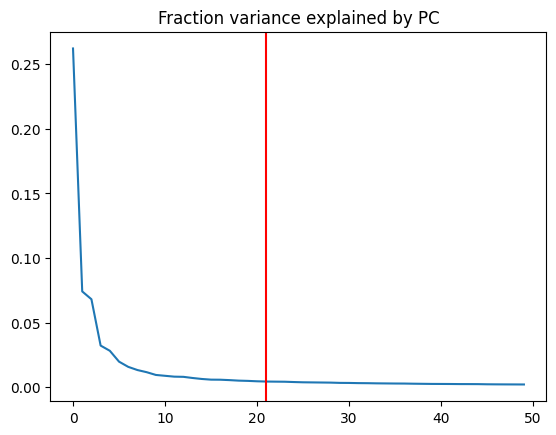

PCA dimensions: 21


In [20]:
# Perform PCA to get fraction variance explained plot
n_comp_pca_test=50
pca = PCA(n_components=n_comp_pca_test)
variant_medianplusemd_scaled = df_profiles_merged[feat_total].values
variant_medianplusemd_pca = pca.fit_transform(variant_medianplusemd_scaled)

# Plot fraction variance explained
plt.plot(list(range(n_comp_pca_test)), pca.explained_variance_ratio_)
plt.title('Fraction variance explained by PC')

# choose number of PCA dim to explain >60% of variance
var_explained_thresh = 0.60
pca_var_explained = np.asarray([np.sum(pca.explained_variance_ratio_[:i]) for i in range(n_comp_pca_test)])
n_comp_pca=sum(pca_var_explained <= var_explained_thresh)
plt.axvline(x=n_comp_pca, c='r')
plt.show()

# perform PCA again
print('PCA dimensions: ' + str(n_comp_pca))
pca = PCA(n_components=n_comp_pca)
variant_medianplusemd_pca = pca.fit_transform(variant_medianplusemd_scaled)
df_variant_medianplusEMD_features_pca = \
    pd.DataFrame(data = variant_medianplusemd_pca, 
                 columns=['PC'+str(i+1) for i in range(n_comp_pca)])
df_variant_medianplusEMD_features_pca['Variant'] = df_profiles_merged['Variant']
df_variant_medianplusEMD_features_pca['Variant_Class'] = df_profiles_merged['Variant_Class']


In [21]:
# Perform UMAP of median and EMD values
umap_model = umap.UMAP(n_neighbors=15, 
                       random_state=42, 
                       metric='cosine',
                       n_components=2)
umap_embedding_means = umap_model.fit_transform(variant_medianplusemd_pca)
df_profiles_merged['UMAP1 total'] = umap_embedding_means[:,0]
df_profiles_merged['UMAP2 total'] = umap_embedding_means[:,1]


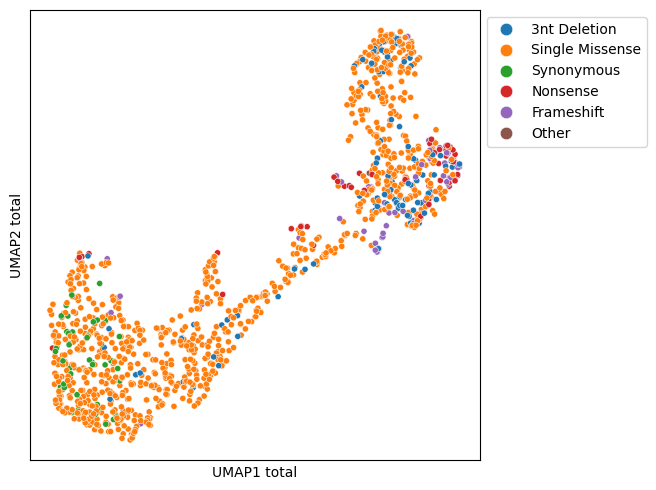

In [22]:
# Plot UMAP
fig,ax=plt.subplots(figsize=(5,5))
sns.scatterplot(data=df_profiles_merged, 
                     x='UMAP1 total', 
                     y='UMAP2 total', 
                     hue='Variant_Class',
                     s=20)
plt.legend(markerscale=2,  
           title='Variant Type')

# Remove x-axis tick labels and ticks
plt.xticks([])

# Remove y-axis tick labels and ticks
plt.yticks([])
plt.tight_layout()
ax.legend(loc='upper left', bbox_to_anchor=(1,1), markerscale=2)
fig.savefig('./consensus_plots/PTENT3.total.UMAP.011425.pdf', dpi=600)
plt.show()


In [686]:
df_profiles_merged.to_csv('./consensus_features/PTENT3.merged.consensusprofiles.011425.csv')

In [24]:
# Load aggregated feature medians for both replicates, zscore and average them
median_df_iPSC_r1 = \
    pd.read_parquet('../PTEN_iPSC_T3_pycytominer_pipelinev2_122224/R1_features/PTENT3R1.iPSC.cellprofiler_121424.median.cellaggregated.parquet')
median_df_iPSC_r2 = \
    pd.read_parquet('../PTEN_iPSC_T3_pycytominer_pipelinev2_122224/R2_features/PTENT3R2.iPSC.cellprofiler_121424.median.cellaggregated.parquet')

median_df_neuron_r1 = \
    pd.read_parquet('./R1_features/PTENT3R1.neuron.cellprofiler_121424.median.cellaggregated.parquet')
median_df_neuron_r2 = \
    pd.read_parquet('./R2_features/PTENT3R2.neuron.cellprofiler_121424.median.cellaggregated.parquet')

# Add N/C ratio
def add_nuc_cyto_ratio(df,
                       col_add='Nuc/Cyto_Intensity_CH1',
                       col_nuc='Mean_Nuclei_Intensity_MeanIntensity_CH1',
                       col_cyto='Mean_Cytoplasm_Intensity_MeanIntensity_CH1'):
    df[col_add] = df[col_nuc]/df[col_cyto]

# For PTEN
add_nuc_cyto_ratio(median_df_iPSC_r1)
add_nuc_cyto_ratio(median_df_iPSC_r2)
add_nuc_cyto_ratio(median_df_neuron_r1)
add_nuc_cyto_ratio(median_df_neuron_r2)

# For pAKT 
add_nuc_cyto_ratio(median_df_iPSC_r1, 
                   col_add='Nuc/Cyto_Intensity_CH3', 
                   col_nuc='Mean_Nuclei_Intensity_MeanIntensity_CH3_Corrected',
                   col_cyto='Mean_Cytoplasm_Intensity_MeanIntensity_CH3_Corrected')
add_nuc_cyto_ratio(median_df_iPSC_r2,
                   col_add='Nuc/Cyto_Intensity_CH3', 
                   col_nuc='Mean_Nuclei_Intensity_MeanIntensity_CH3_Corrected',
                   col_cyto='Mean_Cytoplasm_Intensity_MeanIntensity_CH3_Corrected')
add_nuc_cyto_ratio(median_df_neuron_r1,
                   col_add='Nuc/Cyto_Intensity_CH3', 
                   col_nuc='Mean_Nuclei_Intensity_MeanIntensity_CH3_Corrected',
                   col_cyto='Mean_Cytoplasm_Intensity_MeanIntensity_CH3_Corrected')
add_nuc_cyto_ratio(median_df_neuron_r2,
                   col_add='Nuc/Cyto_Intensity_CH3', 
                   col_nuc='Mean_Nuclei_Intensity_MeanIntensity_CH3_Corrected',
                   col_cyto='Mean_Cytoplasm_Intensity_MeanIntensity_CH3_Corrected')

# Compute average of median features for iPSC and neuron
variant_medians_iPSC = \
    prepare_consensus_variant_scores([median_df_iPSC_r1,median_df_iPSC_r2])
variant_medians_neuron = \
    prepare_consensus_variant_scores([median_df_neuron_r1,median_df_neuron_r2])
variant_medians_merged = \
    variant_medians_iPSC\
        .rename(columns={f:f+'_iPSC' for f in variant_medians_iPSC.columns if f!="Variant"})\
        .merge(variant_medians_neuron\
                   .rename(columns={f:f+'_neuron' for f in variant_medians_neuron.columns if f!="Variant"}),
               on='Variant')
variant_medians_iPSC['Variant_Class'] = \
    pd.Categorical(
        variant_medians_iPSC['Variant'].astype(str).apply(variant_classification),
            categories=mutation_types, 
            ordered=True)
variant_medians_neuron['Variant_Class'] = \
    pd.Categorical(
        variant_medians_neuron['Variant'].astype(str).apply(variant_classification),
            categories=mutation_types, 
            ordered=True)
variant_medians_merged['Variant_Class'] = \
    pd.Categorical(
        variant_medians_merged['Variant'].astype(str).apply(variant_classification),
            categories=mutation_types, 
            ordered=True)
#variant_medians_iPSC.to_csv('./consensus_features/PTEN.iPSC.featuremedians.011525.csv')
#variant_medians_neuron.to_csv('./consensus_features/PTEN.neuron.featuremedians.011525.csv')
#variant_medians_merged.to_csv('./consensus_features/PTEN.merged.featuremedians.011525.csv')


In [25]:
# Add EMD features
EMD_df_iPSC_r1 = \
    pd.read_parquet('../PTEN_iPSC_T3_pycytominer_pipelinev2_122224/R1_features/PTENT3R1.iPSC.cellprofiler_121424.variantmedianplusEMD.IQRthresh.normalized.parquet')
EMD_df_iPSC_r2 = \
    pd.read_parquet('../PTEN_iPSC_T3_pycytominer_pipelinev2_122224/R2_features/PTENT3R2.iPSC.cellprofiler_121424.variantmedianplusEMD.IQRthresh.normalized.parquet')
EMD_df_iPSC_r1.drop(columns=['Variant_Class','Metadata_Object_Count'], inplace=True)
EMD_df_iPSC_r1 = EMD_df_iPSC_r1[['Variant']+[c for c in EMD_df_iPSC_r1.columns if 'EMD' in c]]
EMD_df_iPSC_r2.drop(columns=['Variant_Class','Metadata_Object_Count'], inplace=True)
EMD_df_iPSC_r2 = EMD_df_iPSC_r2[['Variant']+[c for c in EMD_df_iPSC_r2.columns if 'EMD' in c]]
EMD_df_iPSC_r1,EMD_df_iPSC_r2 = \
    (EMD_df_iPSC_r1[list(set(EMD_df_iPSC_r1.columns).intersection(set(EMD_df_iPSC_r2.columns)))],
     EMD_df_iPSC_r2[list(set(EMD_df_iPSC_r1.columns).intersection(set(EMD_df_iPSC_r2.columns)))])

EMD_df_neuron_r1 = \
    pd.read_parquet('./R1_features/PTENT3R1.neuron.cellprofiler_121424.variantmedianplusEMD.IQRthresh.normalized.parquet')
EMD_df_neuron_r2 = \
    pd.read_parquet('./R2_features/PTENT3R2.neuron.cellprofiler_121424.variantmedianplusEMD.IQRthresh.normalized.parquet')
EMD_df_neuron_r1.drop(columns=['Variant_Class','Metadata_Object_Count'], inplace=True)
EMD_df_neuron_r1 = EMD_df_neuron_r1[['Variant']+[c for c in EMD_df_neuron_r1.columns if 'EMD' in c]]
EMD_df_neuron_r2.drop(columns=['Variant_Class','Metadata_Object_Count'], inplace=True)
EMD_df_neuron_r2 = EMD_df_neuron_r2[['Variant']+[c for c in EMD_df_neuron_r2.columns if 'EMD' in c]]
EMD_df_neuron_r1,EMD_df_neuron_r2 = \
    (EMD_df_neuron_r1[list(set(EMD_df_neuron_r1.columns).intersection(set(EMD_df_neuron_r2.columns)))],
     EMD_df_neuron_r2[list(set(EMD_df_neuron_r1.columns).intersection(set(EMD_df_neuron_r2.columns)))])

# Compute average of EMD features for iPSC and neuron
variant_EMD_iPSC = \
    prepare_consensus_variant_scores([EMD_df_iPSC_r1, EMD_df_iPSC_r2], variant_col='Variant')
variant_EMD_iPSC.rename(columns={c:c.split('_EMD')[0] for c in variant_EMD_iPSC}, inplace=True)
variant_EMD_neuron = \
    prepare_consensus_variant_scores([EMD_df_neuron_r1,EMD_df_neuron_r2], variant_col='Variant')
variant_EMD_neuron.rename(columns={c:c.split('_EMD')[0] for c in variant_EMD_neuron}, inplace=True)
variant_EMD_merged = \
    variant_EMD_iPSC\
        .rename(columns={f:f+'_iPSC' for f in variant_EMD_iPSC.columns if f!="Variant"})\
        .merge(variant_EMD_neuron\
                   .rename(columns={f:f+'_neuron' for f in variant_EMD_neuron.columns if f!="Variant"}),
               on='Variant')
variant_EMD_merged['Variant_Class'] = \
    pd.Categorical(
        variant_EMD_merged['Variant'].astype(str).apply(variant_classification),
            categories=mutation_types, 
            ordered=True)
variant_EMD_merged.dropna(axis=1, inplace=True)
#variant_EMD_merged.to_csv('./consensus_features/PTEN.merged.featureEMD.051825.csv')


In [29]:
# Plot morphological impact between iPSC and neuron
# Compute morphological distance
# Define phenotyping impact scores
df_profiles_iPSC_synmedian = \
    df_profiles_iPSC_merged\
        .query('Variant_Class == "Synonymous"')\
        [feat_common_iPSC].agg(np.median)

# compute cosine similarity to median synonymous profile
variant_cosine_similarity_iPSC = \
    cosine_similarity(df_profiles_iPSC_merged[feat_common_iPSC], df_profiles_iPSC_synmedian.values.reshape(1,-1))
df_profiles_iPSC_merged['Morphological Impact Score'] = \
    (1-variant_cosine_similarity_iPSC[:,0])/2

# Define phenotyping impact scores
df_profiles_neuron_synmedian = \
    df_profiles_neuron_merged\
        .query('Variant_Class == "Synonymous"')\
        [feat_common_neuron].agg(np.median)

# compute cosine similarity to median synonymous profile
variant_cosine_similarity_neuron = \
    cosine_similarity(df_profiles_neuron_merged[feat_common_neuron], df_profiles_neuron_synmedian.values.reshape(1,-1))
df_profiles_neuron_merged['Morphological Impact Score'] = \
    (1-variant_cosine_similarity_neuron[:,0])/2

# Add to df profiles merged
df_profiles_merged['Morphological Impact Score iPSC'] = \
    df_profiles_merged\
        .merge(df_profiles_iPSC_merged[['Variant','Morphological Impact Score']],
               on='Variant')\
        ['Morphological Impact Score']
df_profiles_merged['Morphological Impact Score neuron'] = \
    df_profiles_merged\
        .merge(df_profiles_neuron_merged[['Variant','Morphological Impact Score']],
               on='Variant')\
        ['Morphological Impact Score']


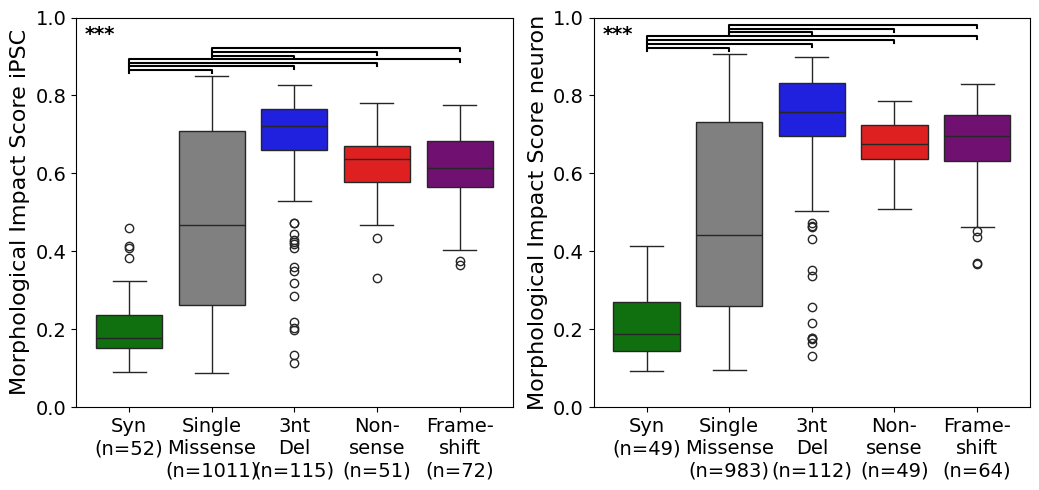

In [30]:
# Plot impact as a function of variant class
wt_controls_name = 'WT\nSamples'
mutation_types_forplotting = [s.replace(" ","\n").replace("Synonymous","Syn") for s in mutation_types]
variant_type_name_forplotting = \
    {
        'Single Missense': 'Single\nMissense',
        'Synonymous': 'Syn',
        'Frameshift': 'Frame-\nshift',
        '3nt Deletion': '3nt\nDel',
        'Nonsense': 'Non-\nsense',
        'Other': 'Other'
    }
variant_type_palette_forplotting = \
    {
        wt_controls_name : 'palegreen',
        'Single\nMissense': 'grey',
        'Syn': 'green',
        'Frame-\nshift': 'purple',
        '3nt\nDel': 'blue',
        'Non-\nsense': 'red',
        'Other': 'brown'
    }

# merge with anderson controls data
df_toplot = df_profiles_iPSC_merged.copy()
df_toplot['Variant Type'] = \
    df_toplot['Variant_Class'].map(lambda x: variant_type_name_forplotting[x])
col_order = ['Syn','Single\nMissense','3nt\nDel','Non-\nsense','Frame-\nshift']
fig, axs = plt.subplots(figsize=(10.5,5),ncols=2)
boxplot_with_significance(
    df=df_toplot,
    x_col='Variant Type',
    y_col='Morphological Impact Score',
    hue_col='Variant Type',  # same as x_col
    order=col_order,
    palette=variant_type_palette_forplotting,
    alpha=0.001,    # Show significance if p < 0.001
    pairs=[("Syn",s) for s in col_order if s!='Syn']+\
            [("Single\nMissense",s) for s in col_order if s not in ["Syn","Single\nMissense"]],
    offset=0.012,
    ax=axs[0],
    anno_sample_sizes=True
)
axs[0].set_ylim(0, 1)

df_toplot = df_profiles_neuron_merged.copy()
df_toplot['Variant Type'] = \
    df_toplot['Variant_Class'].map(lambda x: variant_type_name_forplotting[x])
col_order = ['Syn','Single\nMissense','3nt\nDel','Non-\nsense','Frame-\nshift']

boxplot_with_significance(
    df=df_toplot,
    x_col='Variant Type',
    y_col='Morphological Impact Score',
    hue_col='Variant Type',  # same as x_col
    order=col_order,
    palette=variant_type_palette_forplotting,
    alpha=0.001,    # Show significance if p < 0.001
    pairs=[("Syn",s) for s in col_order if s!='Syn']+\
            [("Single\nMissense",s) for s in col_order if s not in ["Syn","Single\nMissense"]],
    offset=0.012,
    ax=axs[1],
    anno_sample_sizes=True
)
axs[1].set_ylim(0, 1)

# Labels
axs[0].set_ylabel("Morphological Impact Score iPSC", fontsize=16)
axs[1].set_ylabel("Morphological Impact Score neuron", fontsize=16)
axs[0].set_xlabel("")
axs[1].set_xlabel("")

# Font size
axs[0].tick_params(axis='both',labelsize=14)
axs[1].tick_params(axis='both',labelsize=14)

plt.tight_layout()
plt.show()
fig.savefig('./consensus_plots/morphological_impact.variant_class.011525.pdf', dpi=600)


In [127]:
df_profiles_merged.to_csv('./consensus_features/PTENT3.merged.consensusprofiles.withimpact.053025.csv')

In [26]:
# p-values
# import KS statistics
# iPSC
variant_feature_pvalues_iPSC_rep1_df = \
    pd.read_csv('../PTEN_iPSC_T3_pycytominer_pipelinev2_122224/R1_KStest_bycell/results/PTEN_T3R1.bycell.full_p_values.csv')
variant_feature_pvalues_iPSC_rep1_df.index = variant_feature_pvalues_iPSC_rep1_df['Variant']
variant_feature_pvalues_iPSC_rep1_df = variant_feature_pvalues_iPSC_rep1_df.drop('Variant', axis=1)

variant_feature_pvalues_iPSC_rep2_df = \
    pd.read_csv('../PTEN_iPSC_T3_pycytominer_pipelinev2_122224/R2_KStest_bycell/results/PTEN_T3R2.bycell.full_p_values.csv')
variant_feature_pvalues_iPSC_rep2_df.index = variant_feature_pvalues_iPSC_rep2_df['Variant']
variant_feature_pvalues_iPSC_rep2_df = variant_feature_pvalues_iPSC_rep2_df.drop('Variant', axis=1)

# neurons
variant_feature_pvalues_neuron_rep1_df = pd.read_csv('./R1_KStest_bycell/results/PTEN_T3R1.bycell.full_p_values.csv')
variant_feature_pvalues_neuron_rep1_df.index = variant_feature_pvalues_neuron_rep1_df['Variant']
variant_feature_pvalues_neuron_rep1_df = variant_feature_pvalues_neuron_rep1_df.drop('Variant', axis=1)

variant_feature_pvalues_neuron_rep2_df = pd.read_csv('./R2_KStest_bycell/results/PTEN_T3R2.bycell.full_p_values.csv')
variant_feature_pvalues_neuron_rep2_df.index = variant_feature_pvalues_neuron_rep2_df['Variant']
variant_feature_pvalues_neuron_rep2_df = variant_feature_pvalues_neuron_rep2_df.drop('Variant', axis=1)


In [198]:
# perform meta analysis to combine p-values
df_KSpvalues_iPSC = pd.DataFrame(index=df_profiles_merged['Variant'],
                                 columns=variant_feature_pvalues_iPSC_rep1_df.columns)
for v in df_profiles_merged['Variant']:
    for f in variant_feature_pvalues_iPSC_rep1_df.columns:
        df_KSpvalues_iPSC.loc[v,f] = \
            ss.combine_pvalues([variant_feature_pvalues_iPSC_rep1_df.loc[v,f], 
                                variant_feature_pvalues_iPSC_rep2_df.loc[v,f]],
                               method='fisher'
                              )[1]

df_KSpvalues_neuron = pd.DataFrame(index=df_profiles_merged['Variant'],
                                   columns=variant_feature_pvalues_neuron_rep1_df.columns)
for v in df_profiles_merged['Variant']:
    for f in variant_feature_pvalues_neuron_rep1_df.columns:
        df_KSpvalues_neuron.loc[v,f] = \
            ss.combine_pvalues([variant_feature_pvalues_neuron_rep1_df.loc[v,f], 
                                variant_feature_pvalues_neuron_rep2_df.loc[v,f]],
                               method='fisher'
                              )[1]
                       

KeyboardInterrupt: 

In [ ]:
# Save meta-analysis merged p-values
df_KSpvalues_iPSC.to_csv('./consensus_features/PTENT3.iPSC.merged_KSpvalues.011624.csv')
df_KSpvalues_neuron.to_csv('./consensus_features/PTENT3.neuron.merged_KSpvalues.011624.csv')

df_KSpvalues_merged = \
    pd.concat([df_KSpvalues_iPSC.add_suffix('_iPSC'), df_KSpvalues_neuron.add_suffix('_neuron')],axis=1)
df_KSpvalues_merged.to_csv('./consensus_features/PTENT3.total.merged_KSpvalues.011624.csv')


In [10]:
# Filter for variants in df_profiles_merged
genotypes_iPSC_df_filtered = \
    genotypes_iPSC_df\
        .query('aaChanges in @df_profiles_merged["Variant"] or aaChanges == "WT"')\
        .dropna(subset=['AreaShape_Center_X', 'AreaShape_Center_Y'])\
        .query('Replicate == 2')


In [347]:
genotypes_neuron_df_filtered = \
    genotypes_neuron_df\
        .query('aaChanges in @df_profiles_merged["Variant"] or aaChanges == "WT"')\
        .dropna(subset=['AreaShape_Center_X', 'AreaShape_Center_Y'])\
        .query('Replicate == 1')


In [11]:
# Visualize iPSCs
variants_to_viz = \
    ['WT','M134L','E157G','L139F','C124S','C136R']
variants_to_viz_iPSC_byvariant = \
    visualize_cells_byvariant4(
        variants_to_viz, 
        genotypes_iPSC_df_filtered,
        n_square=5,
        crop_size=224,
        plot_middle=100,
        figure_size=10,
        pixel_size=0.0324,
        cellcenterx='AreaShape_Center_X',
        cellcentery='AreaShape_Center_Y',
        output_folder='./crops_iPSC_byvariant_norm2/',
        clip_values=[(500,15000),(200,2000),(200,2000),(100,1000)],
        crop_cell=False
    )


In [349]:
# Visualize neurons
variants_to_viz = \
    ['WT','L139D','E157G','L139F','C124S','C136R']
variants_to_viz_neuron_byvariant = \
    visualize_cells_byvariant4(
        variants_to_viz, 
        genotypes_neuron_df_filtered,
        n_square=5,
        crop_size=224,
        plot_middle=100,
        figure_size=10,
        pixel_size=0.0324,
        cellcenterx='AreaShape_Center_X',
        cellcentery='AreaShape_Center_Y',
        output_folder='./crops_neuron_byvariant_norm2/',
        clip_values=[(500,15000),(200,1500),(25,500),(100,1000)],
        crop_cell=False
    )


In [11]:
# Visualize by feature
features_to_pull = \
    ['Intensity_MeanIntensity_CH1', 
     'Intensity_MeanIntensity_CH3_Corrected',
     'Correlation_Correlation_CH0_CH1']


In [15]:
# Visualize iPS by feature
cell_crops_iPSC_byfeature = \
    visualize_cells_byfeature(
        features_to_pull,
        genotypes_iPSC_df_filtered,
        n_quantiles=10,
        n_square=5,
        crop_size=224,
        plot_middle=100,
        figure_size=10,
        pixel_size=0.0324,
        cellcenterx='AreaShape_Center_X',
        cellcentery='AreaShape_Center_Y',
        output_folder='./feature_crops_PTEN_iPSC_v2/',
        clip_DAPI=(500,15000),
        clip_phenotype=(200,2000),
        crop_cell=False
    )

[Warning] Decile '(0.0147, 0.0154]' for feature 'Intensity_MeanIntensity_CH1' has only 23 cells.
[Warning] Decile '(0.0154, 0.0161]' for feature 'Intensity_MeanIntensity_CH1' has only 24 cells.
[Warning] Decile '(0.0169, 0.018]' for feature 'Intensity_MeanIntensity_CH1' has only 24 cells.
[Warning] Decile '(0.0222, 0.267]' for feature 'Intensity_MeanIntensity_CH1' has only 24 cells.
[Warning] Decile '(-0.0009802, 0.00426]' for feature 'Intensity_MeanIntensity_CH3_Corrected' has only 24 cells.
[Warning] Decile '(0.00426, 0.0044]' for feature 'Intensity_MeanIntensity_CH3_Corrected' has only 24 cells.
[Warning] Decile '(0.00461, 0.00472]' for feature 'Intensity_MeanIntensity_CH3_Corrected' has only 23 cells.
[Warning] Decile '(0.00484, 0.00498]' for feature 'Intensity_MeanIntensity_CH3_Corrected' has only 24 cells.
[Warning] Decile '(-0.403, 0.656]' for feature 'Correlation_Correlation_CH0_CH1' has only 24 cells.
[Warning] Decile '(0.8, 0.825]' for feature 'Correlation_Correlation_CH0_CH1

In [23]:
# Visualize iPS by feature - 4 channels
cell_crops_iPSC_byfeature = \
    visualize_cells_byfeature2(
        features_to_pull,
        genotypes_iPSC_df_filtered,
        n_quantiles=10,
        n_square=5,
        crop_size=224,
        plot_middle=100,
        figure_size=10,
        pixel_size=0.0324,
        cellcenterx='AreaShape_Center_X',
        cellcentery='AreaShape_Center_Y',
        output_folder='./feature_crops_PTEN_iPSC_v3/',
        clip_values=[(500,15000),(200,2000),(200,2000),(100,1000)],
        crop_cell=False
    )

[Warning] Decile '(0.0147, 0.0154]' for feature 'Intensity_MeanIntensity_CH1' has only 23 cells.
[Warning] Decile '(0.0154, 0.0161]' for feature 'Intensity_MeanIntensity_CH1' has only 24 cells.
[Warning] Decile '(0.0169, 0.018]' for feature 'Intensity_MeanIntensity_CH1' has only 24 cells.
[Warning] Decile '(0.0222, 0.267]' for feature 'Intensity_MeanIntensity_CH1' has only 24 cells.
[Warning] Decile '(-0.0009802, 0.00426]' for feature 'Intensity_MeanIntensity_CH3_Corrected' has only 24 cells.
[Warning] Decile '(0.00426, 0.0044]' for feature 'Intensity_MeanIntensity_CH3_Corrected' has only 24 cells.
[Warning] Decile '(0.00461, 0.00472]' for feature 'Intensity_MeanIntensity_CH3_Corrected' has only 23 cells.
[Warning] Decile '(0.00484, 0.00498]' for feature 'Intensity_MeanIntensity_CH3_Corrected' has only 24 cells.
[Warning] Decile '(-0.403, 0.656]' for feature 'Correlation_Correlation_CH0_CH1' has only 24 cells.
[Warning] Decile '(0.8, 0.825]' for feature 'Correlation_Correlation_CH0_CH1

In [134]:
# Visualize iPS by feature - only DAPI/pAkt
cell_crops_iPSC_byfeature = \
    visualize_cells_byfeature(
        features_to_pull,
        genotypes_iPSC_df_filtered,
        n_quantiles=10,
        n_square=5,
        crop_size=224,
        plot_middle=100,
        figure_size=10,
        pixel_size=0.0324,
        cellcenterx='AreaShape_Center_X',
        cellcentery='AreaShape_Center_Y',
        output_folder='./feature_crops_PTEN_iPSC_v4/',
        phenotype_col="pAKTPath",
        DAPI_col="DAPIPath",
        mask_col="CellMaskPath",
        phenotype_ch=0, #red
        clip_DAPI=(500,15000),
        clip_phenotype=(100,1000),
        crop_cell=False
    )

[Warning] Decile '(0.0147, 0.0154]' for feature 'Intensity_MeanIntensity_CH1' has only 23 cells.
[Warning] Decile '(0.0154, 0.0161]' for feature 'Intensity_MeanIntensity_CH1' has only 24 cells.
[Warning] Decile '(0.0169, 0.018]' for feature 'Intensity_MeanIntensity_CH1' has only 24 cells.
[Warning] Decile '(0.0222, 0.267]' for feature 'Intensity_MeanIntensity_CH1' has only 24 cells.
[Warning] Decile '(-0.0009802, 0.00426]' for feature 'Intensity_MeanIntensity_CH3_Corrected' has only 24 cells.
[Warning] Decile '(0.00426, 0.0044]' for feature 'Intensity_MeanIntensity_CH3_Corrected' has only 24 cells.
[Warning] Decile '(0.00461, 0.00472]' for feature 'Intensity_MeanIntensity_CH3_Corrected' has only 23 cells.
[Warning] Decile '(0.00484, 0.00498]' for feature 'Intensity_MeanIntensity_CH3_Corrected' has only 24 cells.
[Warning] Decile '(-0.403, 0.656]' for feature 'Correlation_Correlation_CH0_CH1' has only 24 cells.
[Warning] Decile '(0.8, 0.825]' for feature 'Correlation_Correlation_CH0_CH1